<h3 style="text-align: center;"><b>ПРОЕКТ. Image Generation. CycleGAN.



 Проект выполнен с использованием кода из блокнота ДЗ GAN

In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

from pathlib import Path
from PIL import Image
import itertools
from torchsummary import summary
from torch.optim import lr_scheduler

from torch.autograd import Variable

В качестве обучающей выборки использовалась часть датасета

https://www.kaggle.com/yudhaislamisulistya/plants-type-datasets?select=dataset_type_of_plants

Датасет содержит изображения овощей, возьмем кукурузу и баклажан

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
curr_dir = 'data'
os.makedirs(curr_dir, exist_ok=True)

In [4]:
!unzip -q /content/gdrive/MyDrive/corn_eggplant/corn_test.zip -d data/testA
!unzip -q /content/gdrive/MyDrive/corn_eggplant/eggplant_test.zip -d data/testB

In [ ]:
#!rm -r /content/data/testA
#!rm -r /content/data/testB
#!rm -r /content/data/trainA
#!rm -r /content/data/trainB

In [ ]:
#!ls /content/data/trainA

In [5]:
image_size = 256
batch_size = 4
stats = (0, 0, 0), (1, 1, 1)

In [6]:
def PRE_tr(image):
  return transformations_0(image)

def image2tensor(image, sh=3):
  if sh==3:
    return transformations(image)
  else:
    return transformations_1(image)

In [8]:
transformations=tt.Compose([
    tt.Resize((image_size, image_size)),                          
    tt.ToTensor(),
    tt.Normalize((0, 0, 0), (1, 1, 1))
    ])


number_images=100
DATA_DIR_A=Path('/content/data/testA')
DATA_DIR_B=Path('/content/data/testB')

files_A=list(DATA_DIR_A.rglob('*.jpg'))
files_B=list(DATA_DIR_B.rglob('*.jpg'))
image_folder_A = Path('/content/data/testA')
image_folder_B = Path('/content/data/testB')

test_ds_A =[]
test_ds_B = []
j=0
root_A = '/content/data/testA'
root_B = '/content/data/trainB'
for idx, fname in tqdm(enumerate(files_A), total = len(files_A) if number_images is None else number_images):
    if j == number_images:
      break
    image_temp_A = Image.open(os.path.join(DATA_DIR_A, root_A, fname)).convert('RGB')
    test_ds_A.append(image2tensor(image_temp_A))
    j+=1

j=0
for idx, fname in tqdm(enumerate(files_B), total = len(files_B) if number_images is None else number_images):
    if j == number_images:
      break
    image_temp_B = Image.open(os.path.join(DATA_DIR_B, root_B, fname)).convert('RGB')
    test_ds_B.append(image2tensor(image_temp_B))
    j+=1

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [9]:
test_dl_A = DataLoader(test_ds_A, batch_size=4, shuffle=True, pin_memory=True, num_workers=2, drop_last=True)#num_workers=1, 
test_dl_B = DataLoader(test_ds_B, batch_size=4, shuffle=True, pin_memory=True, num_workers=2, drop_last=True)#num_workers=1, 

In [10]:
### Из ноутбука ДЗ GAN

def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]
    
def show_images(images, nmax=64):
    images = images
    fig, ax = plt.subplots(figsize=(16, 16))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_images_c(images, nmax=64):
    images = images.detach().cpu()
    fig, ax = plt.subplots(figsize=(16, 16))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images in dl:
        show_images(images, nmax)
        break

def show_batch_c(dl, nmax=64, lim=1):
    for images in dl:
        images = images.detach().cpu()
        fig, ax = plt.subplots(figsize=(16, 16))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(denorm(images[:nmax]), nrow=8).permute(1, 2, 0))
        if lim!=1:
          break
        

In [11]:
### Из ноутбука ДЗ GAN

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device



device(type='cuda')

In [13]:
test_dl_A = DeviceDataLoader(test_dl_A, device)
test_dl_B = DeviceDataLoader(test_dl_B, device)

In [ ]:
# Примеры изображений из тестовой выборки

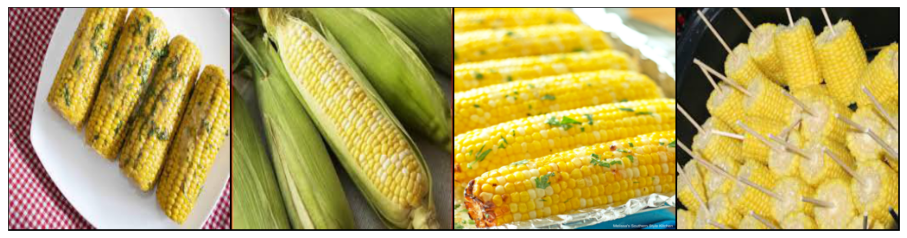

In [14]:
show_batch_c(test_dl_A, lim=0)

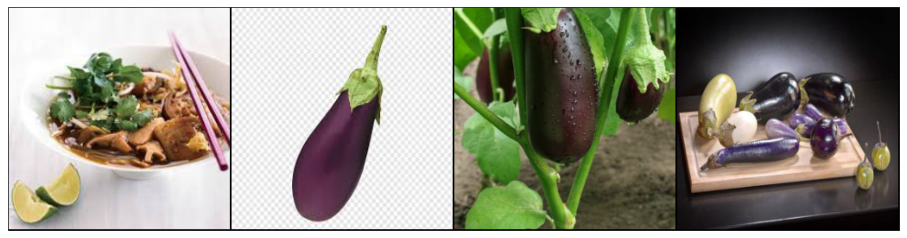

In [15]:
show_batch_c(test_dl_B, lim=0)

In [ ]:
# Генератор

In [20]:
class generator(torch.nn.Module):
  def __init__(self):
    super(generator, self).__init__()

    self.e1 = nn.Sequential(nn.ReflectionPad2d(3),#3*262*262)
                            nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=0),#64*256*256
                            nn.InstanceNorm2d(64),
                            nn.ReLU(True),
                            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),#128*128*128
                            nn.InstanceNorm2d(128),
                            nn.ReLU(True),
                            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),#256*64*64
                            nn.InstanceNorm2d(256),
                            nn.ReLU(True))
    
    self.r1 = nn.Sequential(nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),#256*64*64
                            nn.InstanceNorm2d(256),
                            nn.ReLU(True),
                            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
                            nn.InstanceNorm2d(256))#256*64*64                   

    self.r10 = nn.Sequential(nn.ReLU(True))#256*64*64
    

    self.d1 = nn.Sequential(nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),#512*64*64
                            nn.PixelShuffle(2),#128*128*128
                            nn.InstanceNorm2d(128),
                            nn.ReLU(True),
                            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),#256*128*128
                            nn.PixelShuffle(2),#128*128*128
                            nn.InstanceNorm2d(64),
                            nn.ReLU(True),
                            nn.ReflectionPad2d(3), #64*262*262
                            nn.Conv2d(64, 3, kernel_size=7, stride=1, padding=0),#3*256*256
                            nn.Tanh())

    
  def forward(self, x):
    
    x3 = self.e1(x)#256*64*64

    #1
    x6 = self.r10(x3 + self.r1(x3))#256*64*64
    #2
    x9 = self.r10(x6 + self.r1(x6))#256*64*64
    #3
    x12 = self.r10(x9 + self.r1(x9))#256*64*64
    #4
    x15 = self.r10(x12 + self.r1(x12))#256*64*64
    #5
    x18 = self.r10(x15 + self.r1(x15))#256*64*64
    #6
    x21 = self.r10(x18 + self.r1(x18))#256*64*64
    #7
    x24 = self.r10(x21 + self.r1(x21))#256*64*64
    #8
    x27 = self.r10(x24 + self.r1(x24))#256*64*64
    #9
    x29 = self.r10(x27 + self.r1(x27))#256*64*64
    #10
    x32 = self.d1(x29)#3*256*256

    return x32

In [16]:
### Из ноутбука ДЗ GAN

def show_test(i):
  fig, ax = plt.subplots(figsize=(16, 16))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(i.cpu().detach(), nrow=8).permute(1, 2, 0))

In [17]:
def show_test_2(i, titl=''):
    i = np.clip(i.cpu().detach().numpy(), 0, 1)
    i = torch.tensor(i)
    plt.figure(figsize=(16,16))
    plt.imshow(make_grid(i.cpu().detach(), nrow=8).permute(1, 2, 0))
    plt.axis("off")
    plt.title(titl)
    plt.show()

In [ ]:
# Обучение модели с сохранением послде каждой эпохи на ГДиск

In [21]:
# Загружаем обученные генераторы
trained_g_A2B=torch.load("/content/gdrive/MyDrive/save_models_corn_eggplant/10_model_g_AB.pth")

In [22]:
trained_g_B2A = torch.load("/content/gdrive/MyDrive/save_models_corn_eggplant/10_model_g_BA.pth")

In [ ]:
# Генерируем изображения

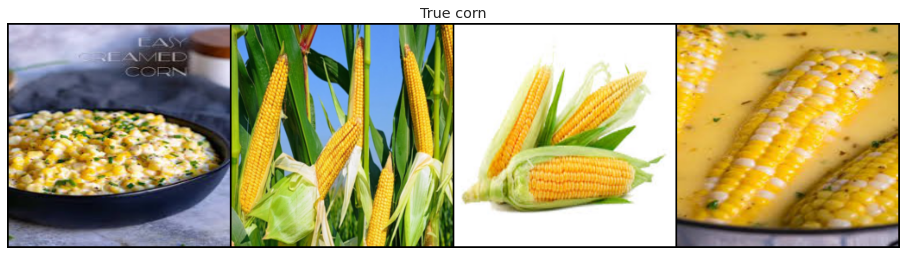

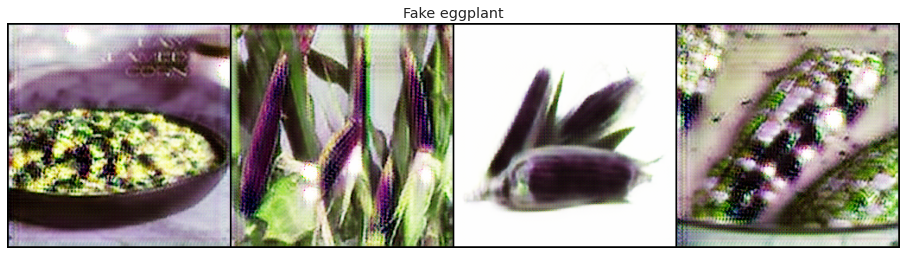

In [28]:
with torch.no_grad():
    for x in test_dl_A:
      show_test_2(x, titl='True corn')
      show_test_2(trained_g_A2B(x), titl='Fake eggplant')
      break

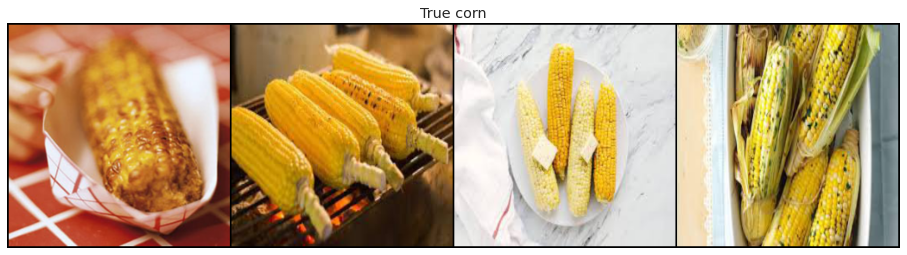

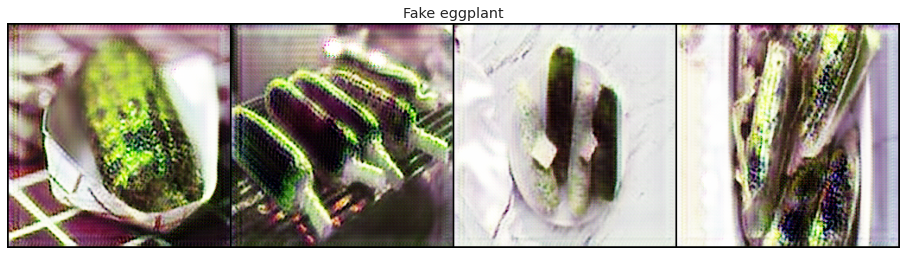

In [24]:
with torch.no_grad():
    for x in test_dl_A:
      show_test_2(x, titl='True corn')
      show_test_2(trained_g_A2B(x), titl='Fake eggplant')
      break

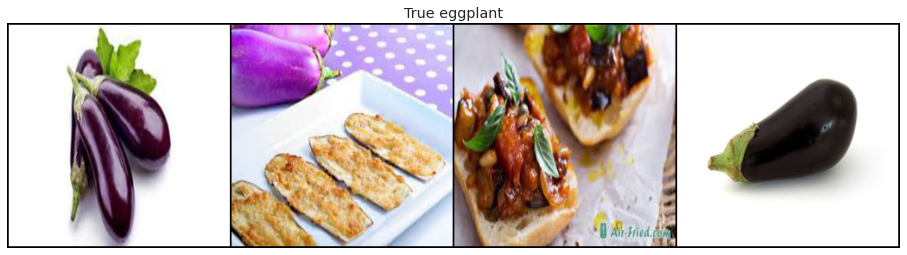

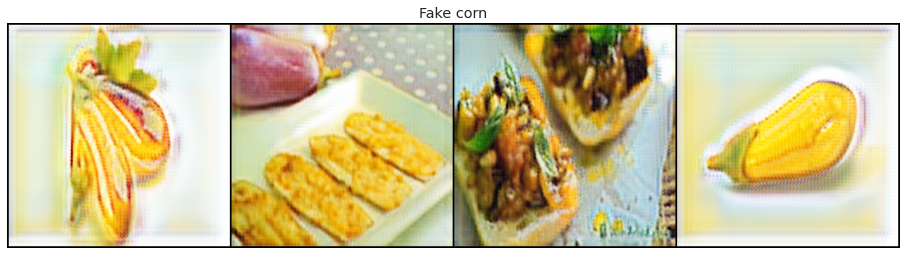

In [25]:
with torch.no_grad():
    for x in test_dl_B:
      show_test_2(x, titl='True eggplant')
      show_test_2(trained_g_B2A(x), titl='Fake corn')
      break

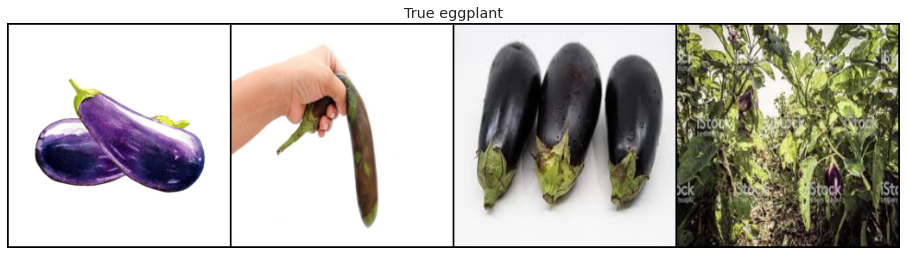

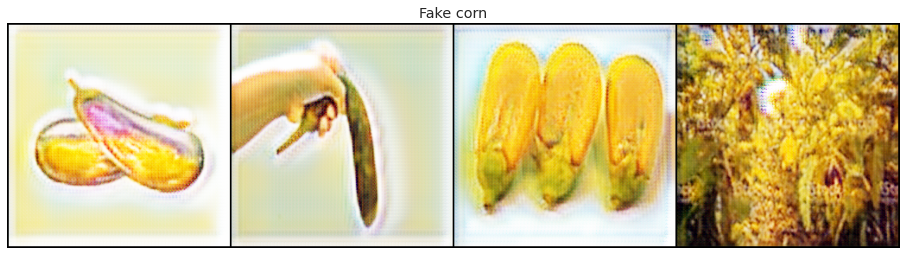

In [26]:
with torch.no_grad():
    for x in test_dl_B:
      show_test_2(x, titl='True eggplant')
      show_test_2(trained_g_B2A(x), titl='Fake corn')
      break